# STEP 2: Finetuning LernnaviBERT on MCQs correct answer prediction

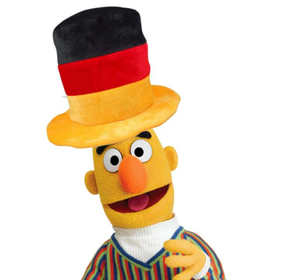

[Source of the image: https://huggingface.co/bert-base-german-cased]

In order to transform a pretrained GermanBERT model in a model able to predict the students’ answers to Multiple Choice Questions (MCQs), we decided to follow a pipeline made of three steps:
1. Finetuning GermanBERT on language modelling considering the Lernnavi dataset. The finetuned model will be renamed "LernnaviBERT" for clarity;
2. Finetuning LernnaviBERT to predict the correct answers to MCQs;
3. Further finetuning the model on the final downstream task, that is the prediction of the answers of a given student to MCQs, taking into account the embedding of the student.

In this notebook, we will perform the second step, that is finetuning LernnaviBERT to predict the correct answer to MCQs. In particular, we will start by introducing some models based on LernnaviBERT, and we will first finetune them on a training set and verify whether they generalize well on a test set. Then, we will train the models on the whole MCQs dataset since we would like our models to know the correct answers to all the MCQs. In this way, we are sure that a failure to predict the answer of a student to an MCQ does not stem from the model not knowing which answer is correct.

## Theoretical motivation

As stated previously, our final goal is creating a model able to predict the answer of a student to a MCQ given the question, the possible answers and some relevant information concerning the student (in the form of an embedding). To reach this goal, we wanted the model to know the correct answers to all the MCQs present in the dataset before attempting to predict the answers of the students. Indeed, we would like the model to exploit the knowledge of the correct answer to a MCQ to predict the student's answers more accurately. For example, if the model knows that a student is answering correctly to all the questions concerning a particular topic, it may decide to predict that the student will answer correctly to a question on that topic, and would therefore need to know which is the correct answer.

We, therefore, finetune two models which have been built upon LernnaviBERT to predict the correct answers to MCQs. We are interested in exploring two settings:
- To verify if the model learns to generalize, that is whether it is able to answer correctly to MCQs after seeing some correct answers to MCQs, we train the model on a training set and evaluate it on a test set.
- To verify whether the model remembers the correct answers to the MCQs it has seen during training, we train the model on the complete dataset and we evaluate it on the same dataset.

It should be noted that, in the next step, we will consider the model trained on the complete dataset. This, however, does not risk to introduce data leakage, as our final goal will be to predict the answer of students to MCQs, not the correct answer. Moreover, we would like the model to learn the correct answers to all MCQs, and exploit this information while predicting the answers given by the students.

## STEP 2

First of all, we mount Google Drive to retrieve Lernnavi's dataset later on.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We now install the various required libraries.

In [2]:
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install nltk==3.8.1 six==1.16.0 urllib3==1.26.15 scipy==1.10.1 numpy==1.22.4 scikit-learn==1.2.2 transformers==4.26.1 apex==0.9.10.dev0 huggingface-hub==0.12.1 tqdm==4.65.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 643.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all th

We then define a set of variables that we will need during the finetuning process.

In [3]:
train_ratio = 0.8
splitting_tolerance = 0.02
batch_size = 16
max_gradient_norm = 1.0
warmup_p = 0.3
learning_rate = 1.75e-5
ROOT_PATH = "/content/drive/MyDrive/MLBD/answer_prediction"

Then, we import all the packages which are necessary to run the notebook.

In [4]:
import sys
sys.path.append(ROOT_PATH)
import pickle
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from dataset_train_eval_extensions import QuestionsDatasetCorrect, train
import torch
from transformers import BertModel, AutoTokenizer, AutoConfig
import numpy as np 
import random
from huggingface_hub import notebook_login

We enable autoreload to ensure that the modifications done to the python file are immediately reflected in the notebook (otherwise, it would be necessary to restart the runtime after each modification).

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Since we want to push the finetuned models to HuggingFace Hub, we have to login to the Hub using HuggingFace token. It should be noted that this cell must be run alone (i.e. the cells should not be run all together up to here), otherwise it would be impossible to insert the token and to login successfully.

In [6]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


At this point, we fix the random seed for reproducibility purposes. It should be noted, in any case, that the randomness is not completely removed, and the results may vary from run to run.

In [7]:
seed = int(0)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
print('Random seed (for reproducibility): ', seed)

Random seed (for reproducibility):  0


We load the dataset containing all the Lernnavi MCQs (questions and possible answers), and the correct answers for the various MCQs.

In [8]:
with open('/content/drive/MyDrive/MLBD/datasets/Lernnavi_MCQs_Correct.pkl', 'rb') as file:
    data_correct = pickle.load(file)

We then preprocess the dataset containing the MCQs and the correct answers by selecting which columns and rows to keep and removing the HTML tags.

In [9]:
# Step 1: Select which columns to keep
data_correct = data_correct[["question", "choices", "correct"]].reset_index(drop = True)

# Step 2: Select which rows to keep
data_correct = data_correct[data_correct["choices"].str.len() > 0]

# Step 3: Remove HTML tags
data_correct["question"] = data_correct["question"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
data_correct["choices"] = data_correct["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])

<ipython-input-9-801e6ef769b8>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data_correct["choices"] = data_correct["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])


At this point, we split the dataset in a training dataset and a validation/test dataset. Since each MCQ is present more than once in the dataset (as we have a datapoint for each student's answer) and we would like to test the model on new MCQs to verify whether it has learnt how to correctly answers MCQs, we will perform the split ensuring that each individual MCQs will be present only in the training set or in the test set. In other words, all the instances of a given MCQ will be only in one of the two datasets that we will create.

In [10]:
# Splitting by question
unique_questions = data_correct['question'].unique()
discrepancy = 1.0
data_train_correct = pd.DataFrame()
data_val_correct = pd.DataFrame()
add_seed = 0
# Splitting until the actual train ratio is close enough to the desired one (within splitting_tolerance)
while abs(discrepancy) > splitting_tolerance:
    # Splitting the unique questions
    train_questions_correct, val_questions_correct = train_test_split(unique_questions, train_size = train_ratio, random_state = seed + add_seed)
    # Determining which rows are in the train and validation sets
    data_train_correct = data_correct[data_correct['question'].isin(train_questions_correct)]
    data_val_correct = data_correct[data_correct['question'].isin(val_questions_correct)]
    # Calculating the actual train ratio
    total_rows = len(data_train_correct) + len(data_val_correct)
    actual_train_ratio = len(data_train_correct) / total_rows
    # Calculating the discrepancy
    discrepancy = actual_train_ratio - train_ratio
    add_seed = add_seed + 1
print(f"Actual train ratio: {actual_train_ratio}")

print(f"Training set size: {len(data_train_correct)}")
print(f"Validation set size: {len(data_val_correct)}")

Actual train ratio: 0.7988476210468407
Training set size: 110360
Validation set size: 27789


At this point, we define the model that we are interested in finetuning. As explained in the notebook created for the previous milestone, we decided to experiment by considering four models based on GermanBERT (or, more precisely, LernnaviBERT) in which the students' embedding are passed in different ways. After testing the four models, we determine that the two best performing models were 'MCQBert1' and 'MCQBert3'. Therefore, for this second step, we will focus on these two models.

We start by defining the model 'MCQBert1' (see scheme below), in which the embeddings of the students are concatenated just before the classification layer. It should be noted that, for this step, we are not interested in the embeddings of the students, as we would like to predict the correct answer to MCQs regardless of the student. Therefore, to avoid confusing the models, we will pass all zero embeddings to them (the student embeddings are zeroed directly while creating the datasets). We still define models in which the embeddings can be inserted, as in the next steps we will be interested in considering the same models and adding the student embeddings.

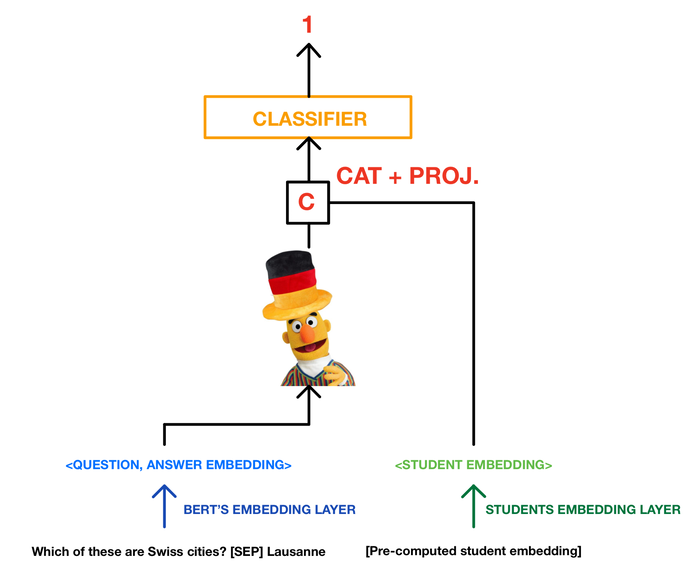

In [11]:
# Embeddings concatenated just before the classification layer
class MCQBert1(BertModel):
    def __init__(self, config, student_embedding_size):
        super().__init__(config)
        self.student_embedding_layer = torch.nn.Linear(student_embedding_size, config.hidden_size)
        
    def forward(self, input_ids, student_embeddings):
        output = super().forward(input_ids)
        output_with_student_embedding = torch.cat((output.last_hidden_state[:, 0, :], self.student_embedding_layer(student_embeddings)), dim = 1)
        return output_with_student_embedding

We now define the model 'MCQBert3' (see scheme below), in which the embeddings are summed at the input of the model.

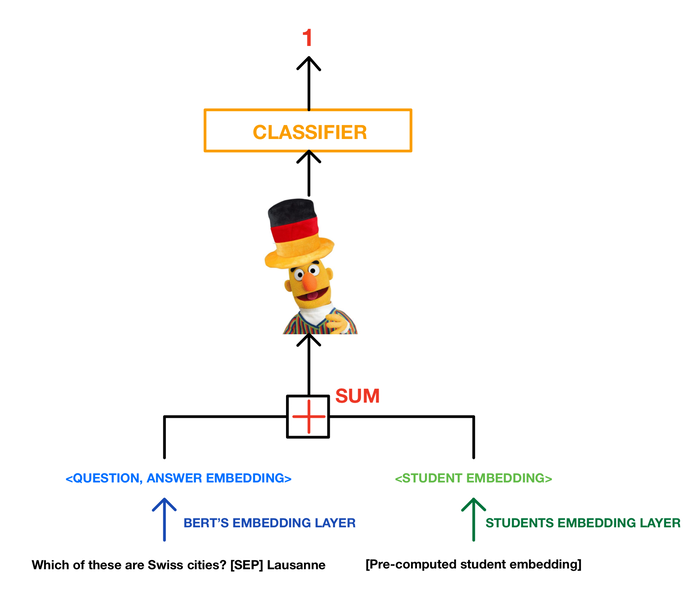

In [12]:
# Embeddings summed at the input of the model
class MCQBert3(BertModel):
    def __init__(self, config, student_embedding_size):
        super().__init__(config)
        self.student_embedding_layer = torch.nn.Linear(student_embedding_size, config.hidden_size)
        
    def forward(self, input_ids, student_embeddings):
        input_embeddings = self.embeddings(input_ids)
        combined_embeddings = input_embeddings + self.student_embedding_layer(student_embeddings).unsqueeze(1).repeat(1, input_embeddings.size(1), 1)
        output = super().forward(inputs_embeds = combined_embeddings)
        return output.last_hidden_state[:, 0, :]

The scheme below shows the complete architecture of the models we considered (the embeddings are not depicted in this case):

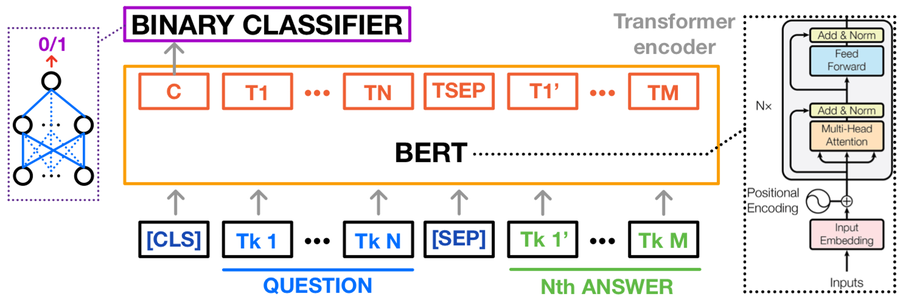

As indicated in the previous milestone, we decided to frame the MCQs prediction problem as a binary classification problem. More in detail, we split each datapoint into multiple datapoints, each of them containing the question and one of the possible answers. The objective of the model is to predict 1 if the possible answer is correct (or, in the next step, if the student selected that possible answer) and to predict 0 if the possible answer is not correct (or, in the next step, if the student did not select that possible answer).

We now define the complete models, which include a classifier head (two linear layers with a ReLU activation in between) so that the model can predict whether each of the possible answers is correct or not. It should be noted that each of the models is based on LernnaviBERT, which we download from the HuggingFace hub. Furthermore, we also finetune a baseline model, which do not contain the embeddings (the baseline will be useful for the next step).

In [13]:
model_name = "lucazed/LernnaviBERT"
config = AutoConfig.from_pretrained(model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_layer_size = 256 # Size of the hidden layer in the classifier
embedding_size = 512 # Size of the student embedding

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Baseline model, based on BertModel (baseline model without embeddings)
modelB = BertModel(config)
modelB.classifier = torch.nn.Sequential(
    torch.nn.Linear(modelB.config.hidden_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
modelB.to(device)

# Model 1, based on MCQBert1
model1 = MCQBert1(config, embedding_size)
model1.classifier = torch.nn.Sequential(
    torch.nn.Linear(model1.config.hidden_size * 2, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
model1.to(device)

# Model 3, based on MCQBert3
model3 = MCQBert3(config, embedding_size)
model3.classifier = torch.nn.Sequential(
    torch.nn.Linear(model3.config.hidden_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
model3.to(device)

MCQBert3(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31102, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

We now create the training dataset and the validation datasets, starting from the split previously done. In this case, we are interested in training the models on the training dataset, and to evaluate them on the validation dataset. In this way, we are able to verify whether the models are able to generalize the prediction to MCQs which they did not see during the training process.

In [14]:
# Training dataset for correct answers
train_dataset_correct = QuestionsDatasetCorrect(tokenizer, data_train_correct, embedding_size)
# Validation dataset for correct answers
dev_dataset_correct = QuestionsDatasetCorrect(tokenizer, data_val_correct, embedding_size)

110360it [01:56, 951.22it/s]
27789it [00:24, 1150.08it/s]


We now perform the training of the baseline model, evaluating it on a separate dataset.

--- MODEL B - Baseline ---
--- No student embeddings ---


Evaluation: 100%|██████████| 6316/6316 [02:04<00:00, 50.73it/s]


Epoch: 0
Training loss: 0.194
Validation loss: 3.577
Accuracy score: 0.630
F1 score for class 0: 0.677
F1 score for class 1: 0.565
Confusion matrix:
[[39292 17902]
 [19524 24336]]
MCC: 0.243


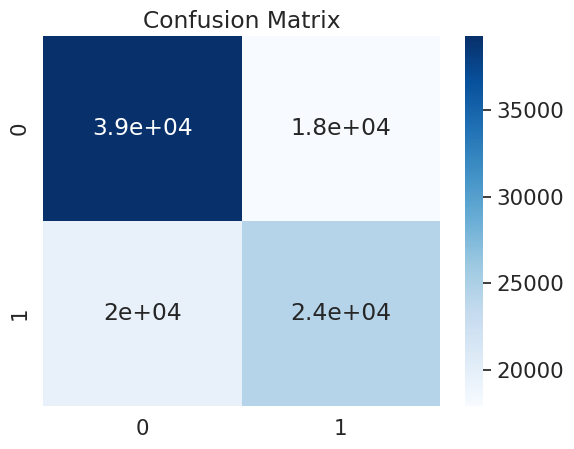

In [15]:
print("--- MODEL B - Baseline ---")
print("--- No student embeddings ---")
bert_model_name = "baseline"
epochs_baseline = 1
train(modelB, train_dataset_correct, dev_dataset_correct, device, epochs_baseline, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=False)

Then, we perform the training of the model 'MCQBert1', again evaluating it on a separate dataset.

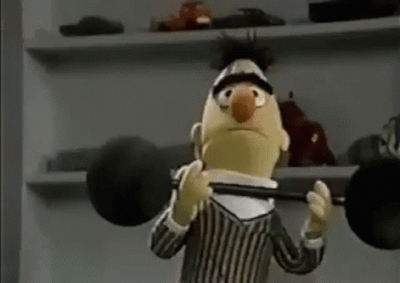

[Source of the image: https://tenor.com/en-GB/view/sesame-street-bert-ernie-exercise-gym-work-out-gif-17243877]

--- MODEL 1 - MCQBert1 ---
--- Student embeddings concatenated just before the classification layer ---


Evaluation: 100%|██████████| 6316/6316 [02:03<00:00, 51.16it/s]


Epoch: 0
Training loss: 0.195
Validation loss: 4.668
Accuracy score: 0.605
F1 score for class 0: 0.660
F1 score for class 1: 0.529
Confusion matrix:
[[38683 18511]
 [21407 22453]]
MCC: 0.190


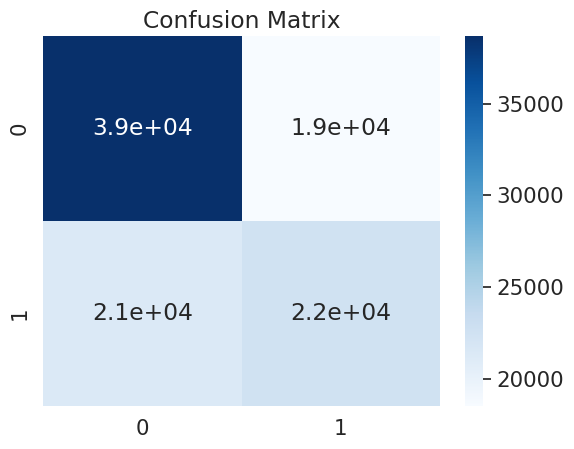

In [16]:
print("--- MODEL 1 - MCQBert1 ---")
print("--- Student embeddings concatenated just before the classification layer ---")
bert_model_name = "mcqbert1"
epochs_mcqbert1 = 1
train(model1, train_dataset_correct, dev_dataset_correct, device, epochs_mcqbert1, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=True)

Finally, we perform the training of the model 'MCQBert3', evaluating it on a separate dataset.

--- MODEL 3 - MCQBert3 ---
--- Student embeddings summed at the input of the model ---


Evaluation: 100%|██████████| 6316/6316 [02:04<00:00, 50.76it/s]


Epoch: 0
Training loss: 0.212
Validation loss: 3.034
Accuracy score: 0.740
F1 score for class 0: 0.796
F1 score for class 1: 0.642
Confusion matrix:
[[51237  5957]
 [20284 23576]]
MCC: 0.472


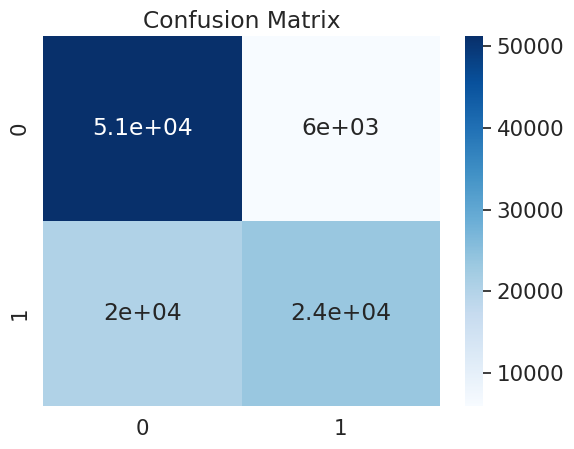

In [17]:
print("--- MODEL 3 - MCQBert3 ---")
print("--- Student embeddings summed at the input of the model ---")
bert_model_name = "mcqbert3"
epochs_mcqbert3 = 1
train(model3, train_dataset_correct, dev_dataset_correct, device, epochs_mcqbert3, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=True)

All the three models demonstrate a reasonable performance, showing that they can identify, up to a certain point, the correct answers to MCQs. It should be noted that this task is quite challenging for the models, as determining the correct answer to a multiple choice question is not a trivial task, especially for models based on the BERT architecture. A result which is perhaps a bit surprising is that MCQBert3 performed significantly better than the other two models: the average F1 score is 0.719 against the 0.621 of the baseline and the 0.5945 of MCQBert1. While MCQBert1 and MCQBert3 are quite different from an architectural perspective also if zero embeddings are considered (mainly since MCQBert1 has a classifier in which the input dimension is larger, since it also receives the concatenated embeddings), it is harder to find differences between the Baseline model and MCQBert3 which could justify such difference in performance.

At this point, we are interested in training again the models on the complete dataset (containing both the training dataset and the validation/test dataset). We therefore define again the models that we will consider.

In [18]:
model_name = "lucazed/LernnaviBERT"
config = AutoConfig.from_pretrained(model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_layer_size = 256 # Size of the hidden layer in the classifier
embedding_size = 512 # Size of the student embedding

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Baseline model, based on BertModel (baseline model without embeddings)
modelB = BertModel(config)
modelB.classifier = torch.nn.Sequential(
    torch.nn.Linear(modelB.config.hidden_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
modelB.to(device)

# Model 1, based on MCQBert1
model1 = MCQBert1(config, embedding_size)
model1.classifier = torch.nn.Sequential(
    torch.nn.Linear(model1.config.hidden_size * 2, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
model1.to(device)

# Model 3, based on MCQBert3
model3 = MCQBert3(config, embedding_size)
model3.classifier = torch.nn.Sequential(
    torch.nn.Linear(model3.config.hidden_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
model3.to(device)

MCQBert3(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31102, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

At this point, we define a dataset containing all the MCQs samples from the Lernnavi dataset.

In [19]:
dataset_correct = QuestionsDatasetCorrect(tokenizer, data_correct, embedding_size)

138149it [02:17, 1003.20it/s]


We now finetune the baseline model to be able to predict the correct answers to MCQs, and we evaluate it on the same datapoints used for training to verify whether the model is able to remember the correct answers after seeing them.

--- MODEL B - Baseline ---
--- No student embeddings ---


Evaluation: 100%|██████████| 33824/33824 [11:23<00:00, 49.47it/s]


Epoch: 0
Training loss: 0.192
Validation loss: 0.031
Accuracy score: 0.992
F1 score for class 0: 0.993
F1 score for class 1: 0.989
Confusion matrix:
[[326739   3872]
 [   624 209947]]
MCC: 0.983


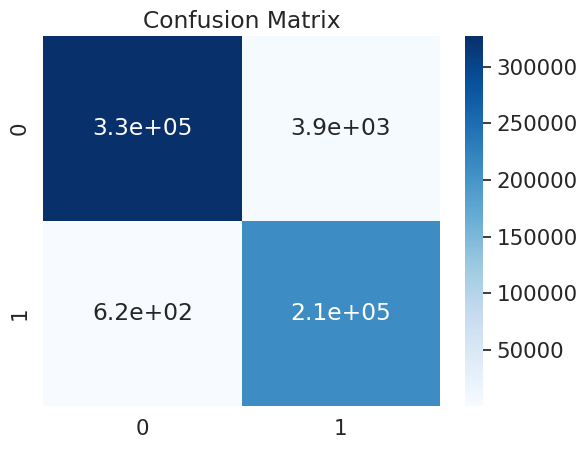

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/lucazed/LernnaviBERT_baseline_correct_answers/commit/14b5e748ee4a778a319e9a0c974a10ae47464bd4', commit_message='Upload model', commit_description='', oid='14b5e748ee4a778a319e9a0c974a10ae47464bd4', pr_url=None, pr_revision=None, pr_num=None)

In [20]:
print("--- MODEL B - Baseline ---")
print("--- No student embeddings ---")
bert_model_name = "baseline"
epochs_basline = 1
train(modelB, dataset_correct, dataset_correct, device, epochs_basline, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=False)

modelB.push_to_hub("lucazed/LernnaviBERT_"+bert_model_name+"_correct_answers")

Then, we finetune the model 'MCQBert1' to be able to predict the correct answers to MCQs. We evaluate it on the same datapoints used for training to verify whether the model is able to remember the correct answers after seeing them.

--- MODEL 1 - MCQBert1 ---
--- Student embeddings concatenated just before the classification layer ---


Evaluation: 100%|██████████| 33824/33824 [11:31<00:00, 48.92it/s]


Epoch: 0
Training loss: 0.234
Validation loss: 0.110
Accuracy score: 0.983
F1 score for class 0: 0.986
F1 score for class 1: 0.978
Confusion matrix:
[[325209   5402]
 [  3873 206698]]
MCC: 0.964


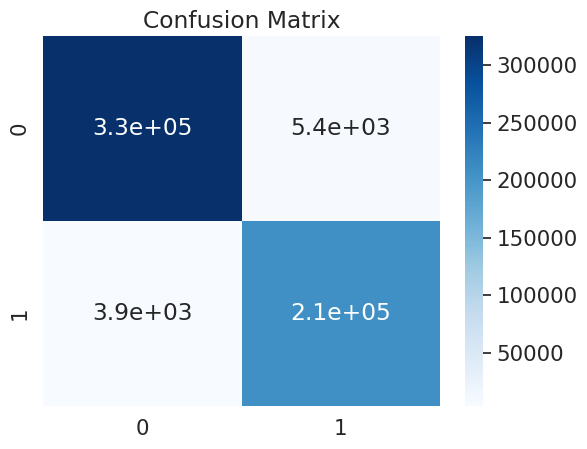

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/lucazed/LernnaviBERT_mcqbert1_correct_answers/commit/8b7ad2c8d3783c3e11ab0b41241b54e5a5ad3da2', commit_message='Upload MCQBert1', commit_description='', oid='8b7ad2c8d3783c3e11ab0b41241b54e5a5ad3da2', pr_url=None, pr_revision=None, pr_num=None)

In [21]:
print("--- MODEL 1 - MCQBert1 ---")
print("--- Student embeddings concatenated just before the classification layer ---")
bert_model_name = "mcqbert1"
epochs_mcqbert1 = 1
train(model1, dataset_correct, dataset_correct, device, epochs_mcqbert1, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=True)

model1.push_to_hub("lucazed/LernnaviBERT_"+bert_model_name+"_correct_answers")

Finally, we finetune the model 'MCQBert3' to be able to predict the correct answers to MCQs. We evaluate it on the same datapoints used for training to verify whether the model is able to remember the correct answers after seeing them.

--- MODEL 3 - MCQBert3 ---
--- Student embeddings summed at the input of the model ---


Evaluation: 100%|██████████| 33824/33824 [11:41<00:00, 48.19it/s]


Epoch: 0
Training loss: 0.212
Validation loss: 0.553
Accuracy score: 0.835
F1 score for class 0: 0.881
F1 score for class 1: 0.731
Confusion matrix:
[[330511    100]
 [ 89317 121254]]
MCC: 0.673


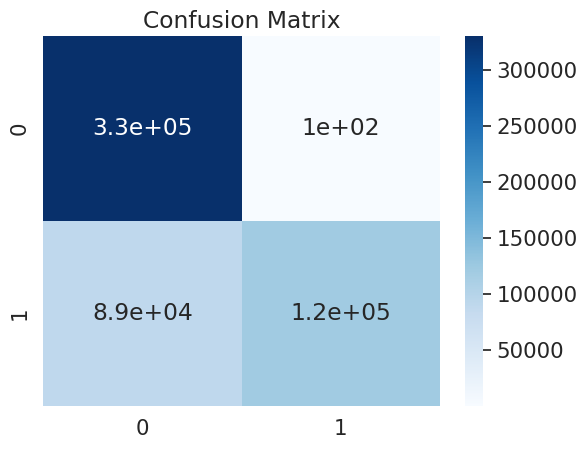

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/lucazed/LernnaviBERT_mcqbert3_correct_answers/commit/d723c80ec1f16c8307ed569b42a75c567ee3467f', commit_message='Upload MCQBert3', commit_description='', oid='d723c80ec1f16c8307ed569b42a75c567ee3467f', pr_url=None, pr_revision=None, pr_num=None)

In [22]:
print("--- MODEL 3 - MCQBert3 ---")
print("--- Student embeddings summed at the input of the model ---")
bert_model_name = "mcqbert3"
epochs_mcqbert3 = 1
train(model3, dataset_correct, dataset_correct, device, epochs_mcqbert3, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=True)

model3.push_to_hub("lucazed/LernnaviBERT_"+bert_model_name+"_correct_answers")

From the results, it is possible to notice that the models tend to recall the correct answers very well, as both the Baseline model and MCQBert1 achieve almost perfect performance on this task. This means that after the finetuning process, the models have learnt the correct answers to the vast majority of the MCQs present in the dataset, and we can therefore exploit this knowledge in the next step. Once again, the performance obtained by MCQBert3 is puzzling, this time in a negative way. Indeed, although the performance remains more than reasonable in this case, this model seems to recall the correct answer much worse than the other two. This difference, which was not observed during the previous runs of the notebooks (with the same datapoints and the same model) may be caused by stochasticity in the training process.